In [187]:
import sys
sys.path.append("/scratch/group/csce435-f24/python-3.10.4/lib/python3.10/site-packages")
sys.path.append("/scratch/group/csce435-f24/thicket")
from glob import glob

import math
import matplotlib.pyplot as plt
import pandas as pd

import thicket as th

Read all files

In [188]:
#1_trial is a name of a folder containing the cali files, you may create a folder with a different name and replace the folder name here
tk = th.Thicket.from_caliperreader(glob("./calipers/*.cali"))

(2/2) Creating Thicket: 100%|██████████| 279/279 [00:09<00:00, 29.45it/s]


View Calltree

In [189]:
print(tk.tree(metric_column="Avg time/rank"))
# tk.metadata

  _____ _     _      _        _   
 |_   _| |__ (_) ___| | _____| |_ 
   | | | '_ \| |/ __| |/ / _ \ __|
   | | | | | | | (__|   <  __/ |_ 
   |_| |_| |_|_|\___|_|\_\___|\__|  v2024.1.0

27.759 main
├─ 16.745 MPI_Comm_dup
├─ 0.000 MPI_Finalize
├─ 0.000 MPI_Finalized
├─ 0.000 MPI_Initialized
├─ 10.468 comm
│  ├─ 5.902 comm_large
│  │  ├─ 0.043 MPI_Allreduce
│  │  ├─ 0.002 MPI_Gather
│  │  └─ 5.850 MPI_Scatterv
│  └─ 4.566 comm_small
│     └─ 4.566 MPI_Reduce
├─ 0.277 comp
│  ├─ 20.550 comp_large
│  └─ 0.117 comp_small
├─ 0.917 correctness_check
└─ 0.259 data_init_runtime

Legend (Metric: Avg time/rank Min: 0.00 Max: 27.76 indices: {'profile': 1264324})
█ 24.98 - 27.76
█ 19.43 - 24.98
█ 13.88 - 19.43
█ 8.33 - 13.88
█ 2.78 - 8.33
█ 0.00 - 2.78

name User code    ◀  Only in left graph    ▶  Only in right graph



Group Performance data by `matrix_size` in the Thicket metadata table.

In [190]:
tk.metadata_column_to_perfdata("num_procs")
tk.metadata_column_to_perfdata("array_size")
tk.metadata_column_to_perfdata("array_type")

tk.dataframe = tk.dataframe.reset_index().set_index(["node", "num_procs", "array_size", "array_type"]).sort_index()

tk.dataframe.head(100)
# print(tk.dataframe)

profile  \
node                                 num_procs array_size array_type                
{'name': 'main', 'type': 'function'} 2         65536      OnePrecPret  1603607452   
                                                          Random       2877582065   
                                                          Reverse      1057032954   
                                                          Sorted       1574391725   
                                               262144     OnePrecPret  4161004083   
...                                                                           ...   
                                     16        1048576    Sorted       4219939461   
                                               4194304    OnePrecPret  3360821717   
                                                          Random        296470190   
                                                          Reverse      1174522817   
                                                          Sorted         29637584   

                                                                       nid  \
node                                 num_procs array_size array_type         
{'name': 'main', 'type': 'function'} 2         65536      OnePrecPret  1.0   
                                                          Random       1.0   
                                                          Reverse      1.0   
                                                          Sorted       1.0   
                                               262144     OnePrecPret  1.0   
...                                                                    ...   
                                     16        1048576    Sorted       1.0   
                                               4194304    OnePrecPret  1.0   
                                                          Random       1.0   
                                                          Reverse      1.0   
                                                          Sorted       1.0   

                                                                        spot.channel  \
node                                 num_procs array_size array_type                   
{'name': 'main', 'type': 'function'} 2         65536      OnePrecPret  regionprofile   
                                                          Random       regionprofile   
                                                          Reverse      regionprofile   
                                                          Sorted       regionprofile   
                                               262144     OnePrecPret  regionprofile   
...                                                                              ...   
                                     16        1048576    Sorted       regionprofile   
                                               4194304    OnePrecPret  regionprofile   
                                                          Random       regionprofile   
                                                          Reverse      regionprofile   
                                                          Sorted       regionprofile   

                                                                       Min time/rank  \
node                                 num_procs array_size array_type                   
{'name': 'main', 'type': 'function'} 2         65536      OnePrecPret       0.022512   
                                                          Random            0.035962   
                                                          Reverse           0.022908   
                                                          Sorted            0.015423   
                                               262144     OnePrecPret       0.066071   
...                                                                              ...   
                                     16        1048576    Sorted            0.222097   
                

In [191]:
# Define common variables
processes = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
array_sizes = [65536, 262144, 1048576, 4194304, 16777216, 67108864, 268435456]
array_types = ["Random", "Sorted", "Reverse", "OnePrecPret"]

In [192]:
# Change font size for all plots
plt.rcParams.update({"font.size": 20})

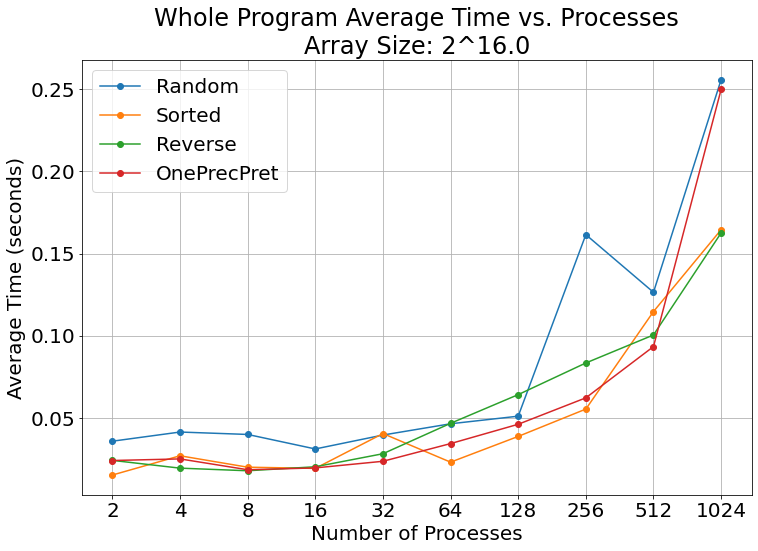

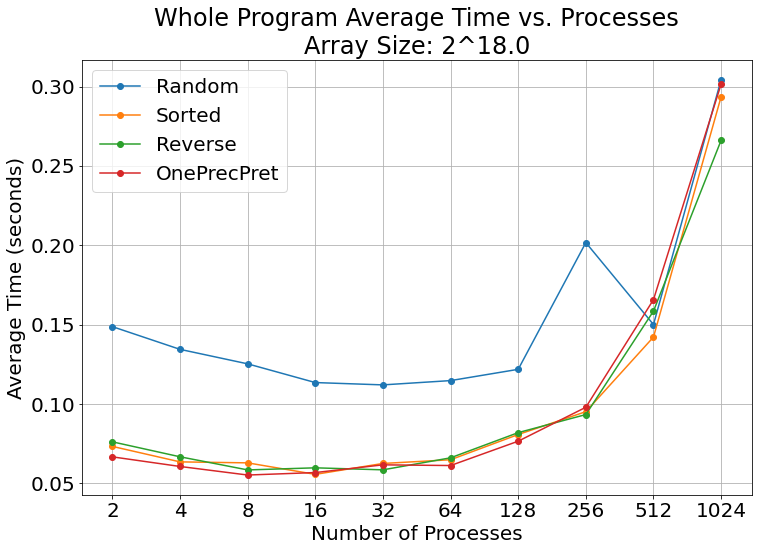

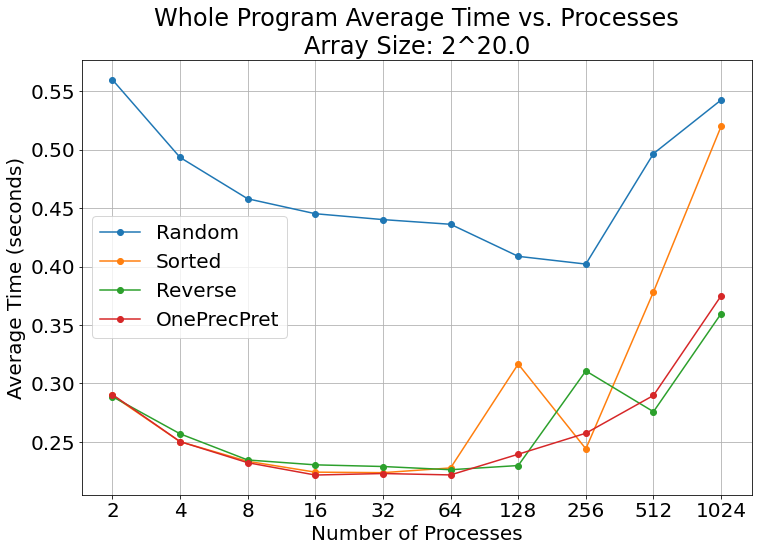

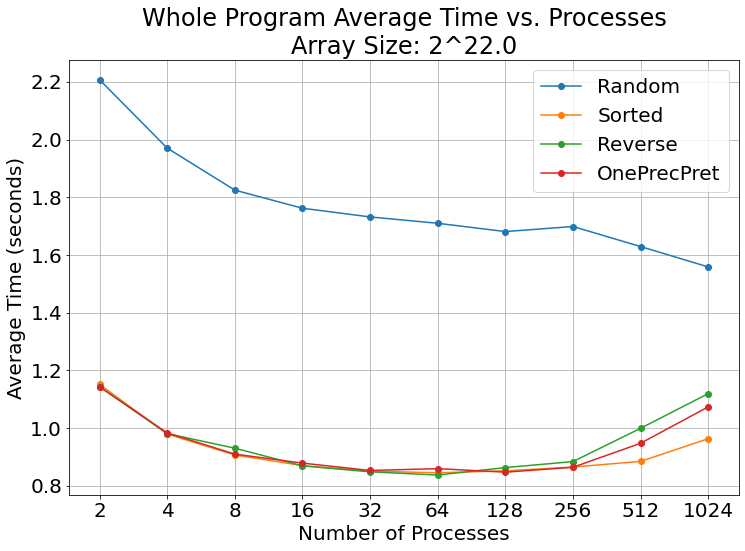

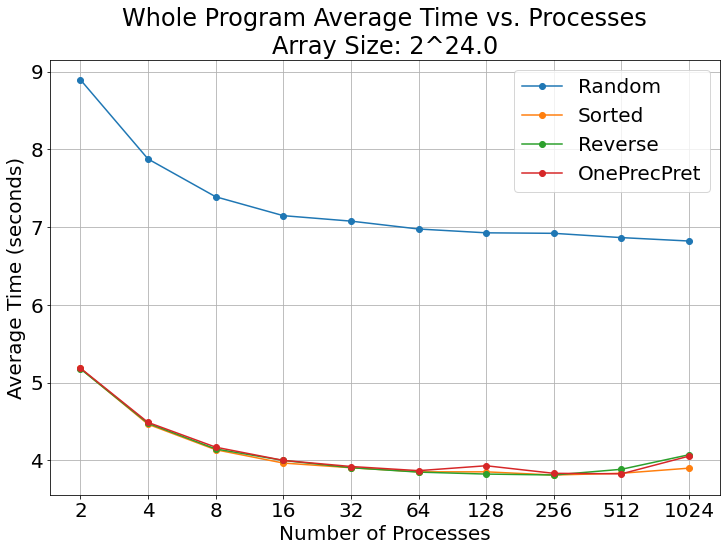

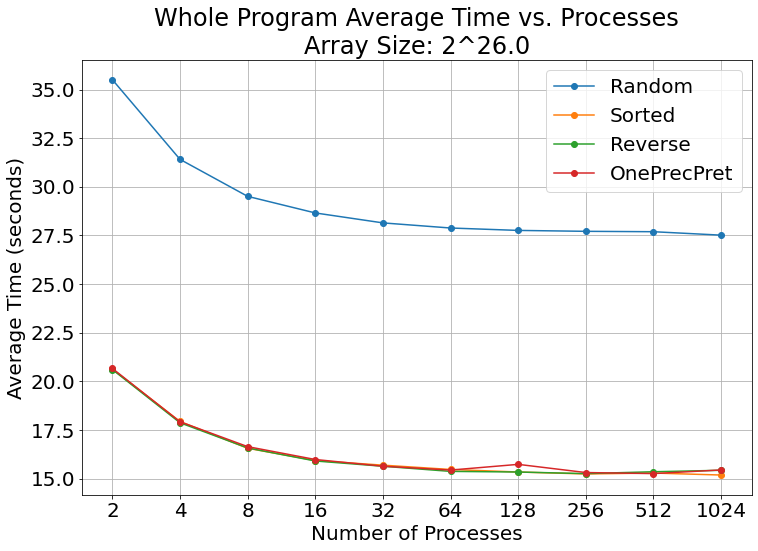

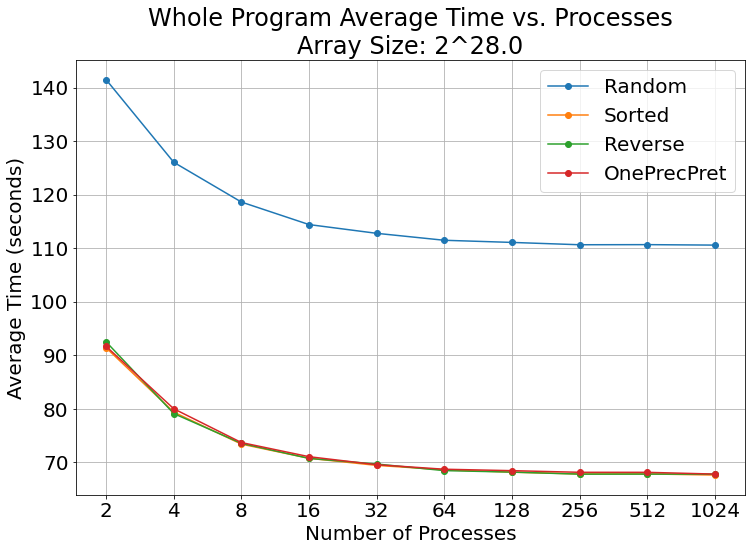

In [193]:
import matplotlib.pyplot as plt

# STRONG SCALING WHOPE PROGRAM PLOT
def extract_and_plot_times(array_siz, tk): # Define the types for which we want to plot (e.g., 1: 'Random', 2: 'Sorted', 3: 'Reverse Sorted')

    # Define sections of timing data to analyze
    timing_sections = {
        'whole_program': 'main',
        'initialization': 'data_init_runtime',
        'communication': 'comm',
        'computation': 'comp'
    }

    def plot_timing_section(array_size, section_name, marker_name, processes):
        plt.figure(figsize=(12, 8))

        # Loop over each array type to get its average times
        for array_type in array_types:
            # Group data and calculate averages for each array type
            avg_times = tk.dataframe.groupby(['num_procs', 'array_size', 'array_type', 'name']).min()['Avg time/rank']
            avg_times_list = []

            for num_proc in processes:
                try:
                    # Append the average times for each process count for the current array type
                    #andrew is really cool :D
                    # thank you
                    avg_times_list.append(avg_times.loc[(num_proc, array_size, array_type, marker_name)])
                except KeyError:
                    print(f"Missing data for process count {num_proc} and array type {array_type}")
                    continue

            indices = list(range(len(avg_times_list)))  # Uniform spacing
            plt.plot(indices, avg_times_list, marker='o', label=f'{array_type}')

        plt.title(f'{section_name} Average Time vs. Processes\nArray Size: 2^{math.log2(array_size)}')
        plt.xlabel('Number of Processes')
        plt.ylabel('Average Time (seconds)')
        plt.xticks(indices, processes)  # Set custom x-axis labels for processes
        plt.legend()
        plt.grid(True)
        plt.show()

    # Define the process counts explicitly
    processes = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
    
    for a_size in array_sizes:
        plot_timing_section(a_size, 'Whole Program', timing_sections['whole_program'], processes)
#         plot_timing_section('Total Communication', 'comm', processes)
#         plot_timing_section('Total Computation', timing_sections['computation'], processes)
    
# updated so that array size doesn't matter
extract_and_plot_times(int(2**22), tk)

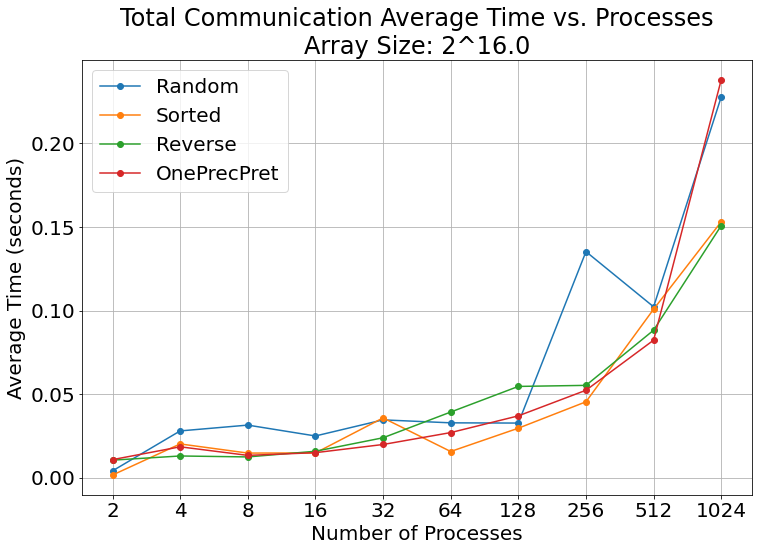

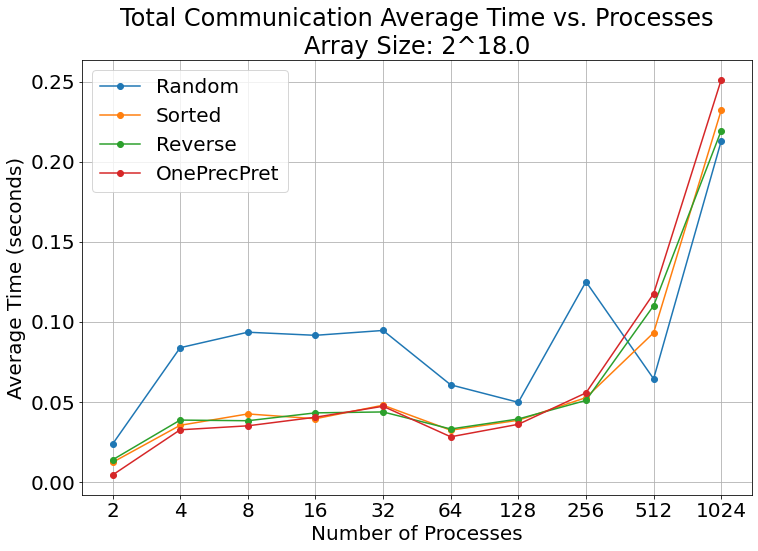

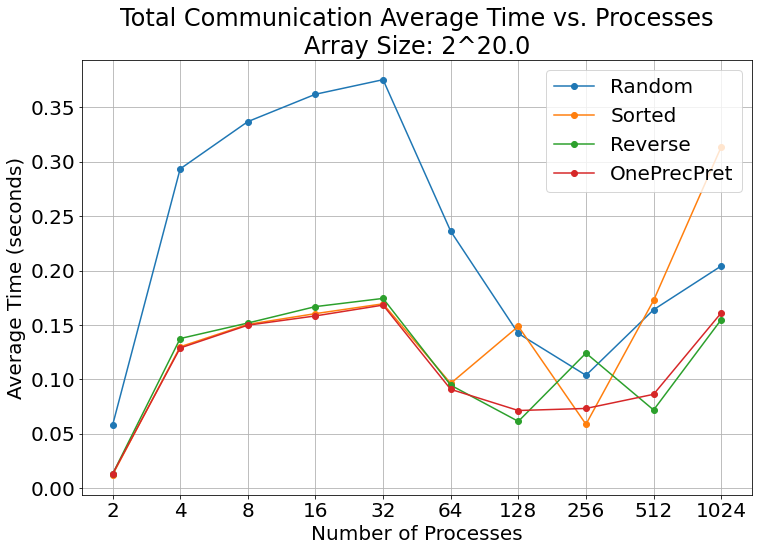

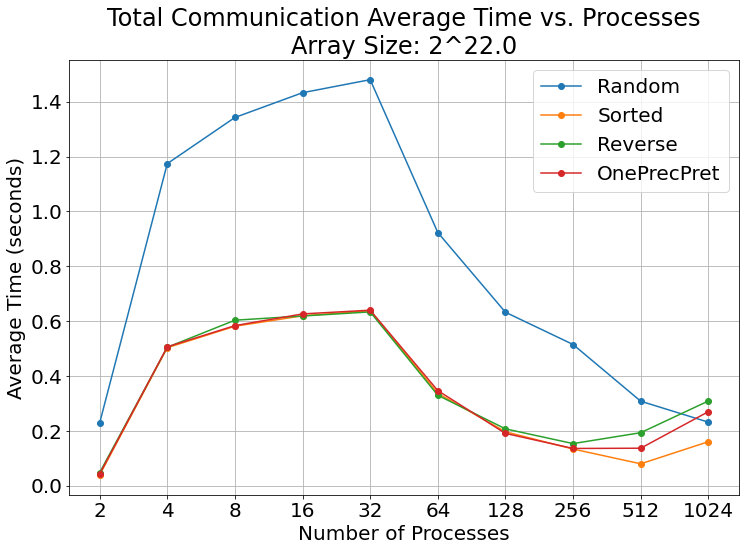

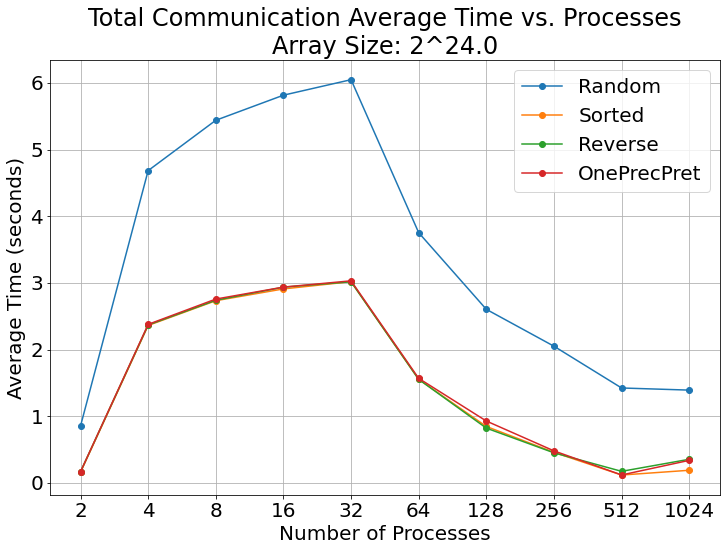

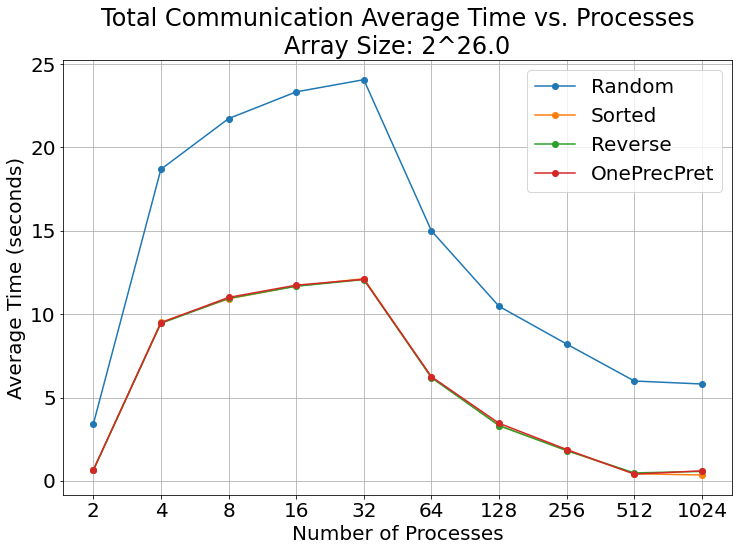

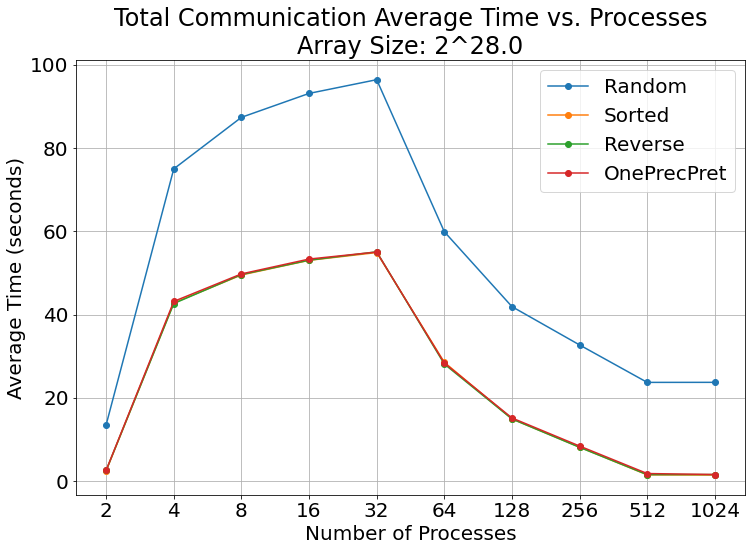

In [194]:
import matplotlib.pyplot as plt

# STRONG SCALING COMMUNICATION TOTAL
def extract_and_plot_times(array_siz, tk): # Define the types for which we want to plot (e.g., 1: 'Random', 2: 'Sorted', 3: 'Reverse Sorted')

    # Define sections of timing data to analyze
    timing_sections = {
        'whole_program': 'main',
        'initialization': 'data_init_runtime',
        'communication': 'comm',
        'computation': 'comp'
    }

    def plot_timing_section(array_size, section_name, marker_name, processes):
        plt.figure(figsize=(12, 8))

        # Loop over each array type to get its average times
        for array_type in array_types:
            # Group data and calculate averages for each array type
            avg_times = tk.dataframe.groupby(['num_procs', 'array_size', 'array_type', 'name']).min()['Avg time/rank']
            avg_times_list = []

            for num_proc in processes:
                try:
                    # Append the average times for each process count for the current array type
                    #andrew is really cool :D
                    # thank you
                    avg_times_list.append(avg_times.loc[(num_proc, array_size, array_type, marker_name)])
                except KeyError:
                    print(f"Missing data for process count {num_proc} and array type {array_type}")
                    continue

            indices = list(range(len(avg_times_list)))  # Uniform spacing
            plt.plot(indices, avg_times_list, marker='o', label=f'{array_type}')

        plt.title(f'{section_name} Average Time vs. Processes\nArray Size: 2^{math.log2(array_size)}')
        plt.xlabel('Number of Processes')
        plt.ylabel('Average Time (seconds)')
        plt.xticks(indices, processes)  # Set custom x-axis labels for processes
        plt.legend()
        plt.grid(True)
        plt.show()

    # Define the process counts explicitly
    processes = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
    
    for a_size in array_sizes:
#         plot_timing_section(a_size, 'Whole Program', timing_sections['whole_program'], processes)
        plot_timing_section(a_size, 'Total Communication', 'comm', processes)
#         plot_timing_section('Total Computation', timing_sections['computation'], processes)
    
# updated so that array size doesn't matter
extract_and_plot_times(int(2**22), tk)

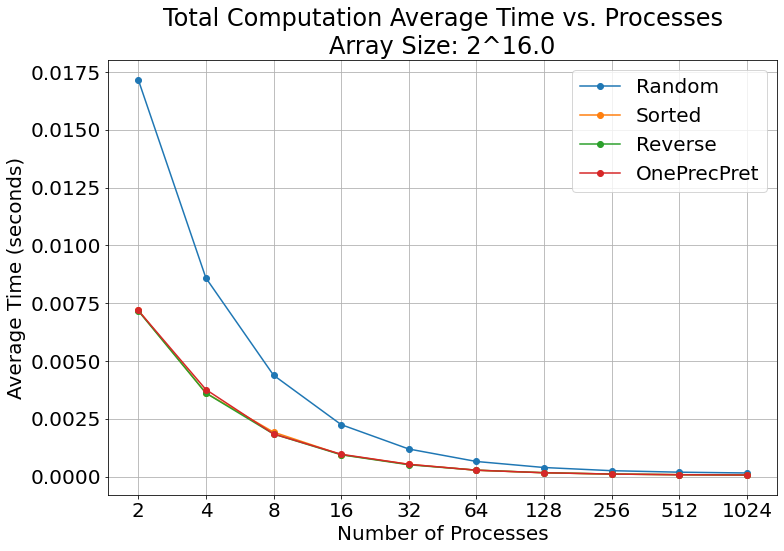

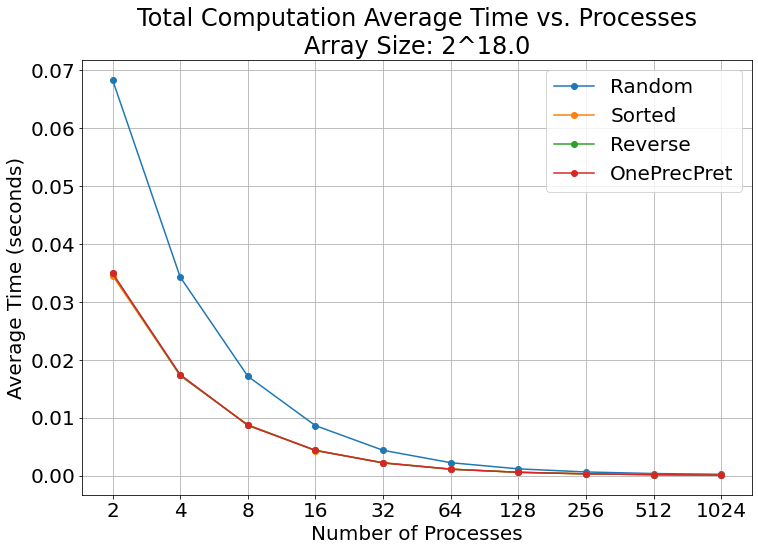

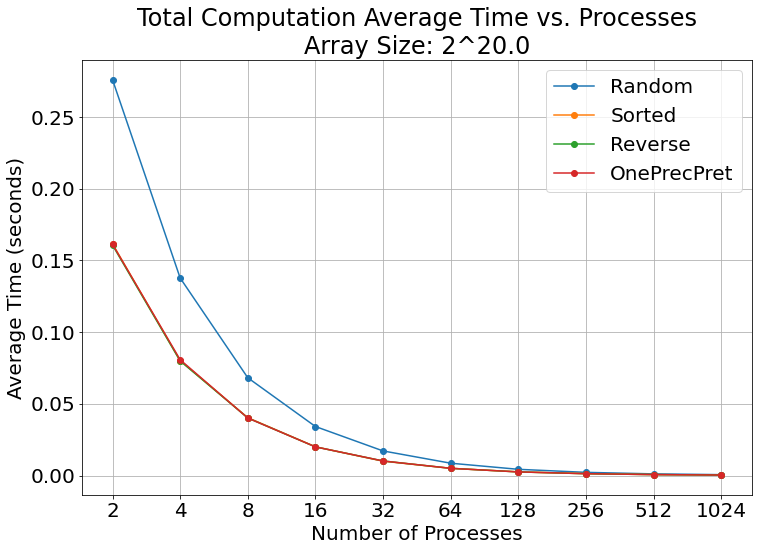

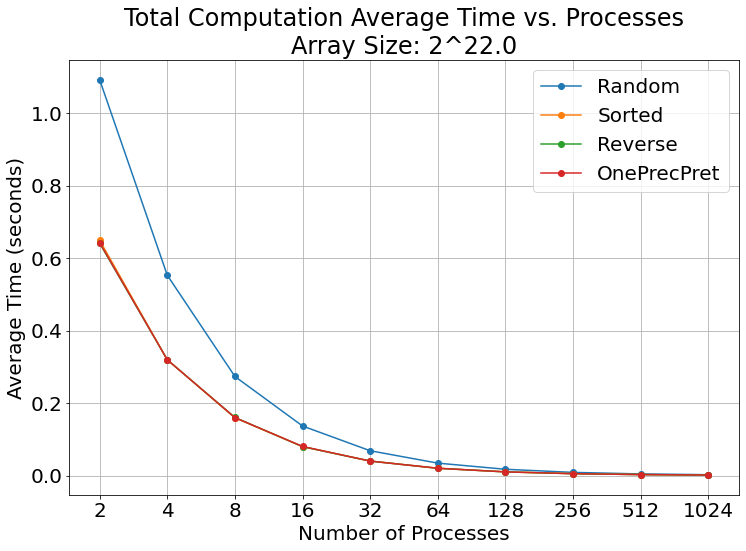

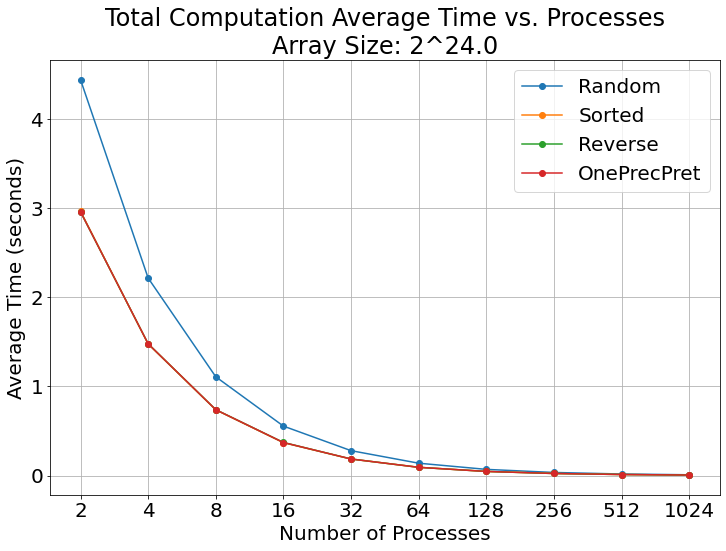

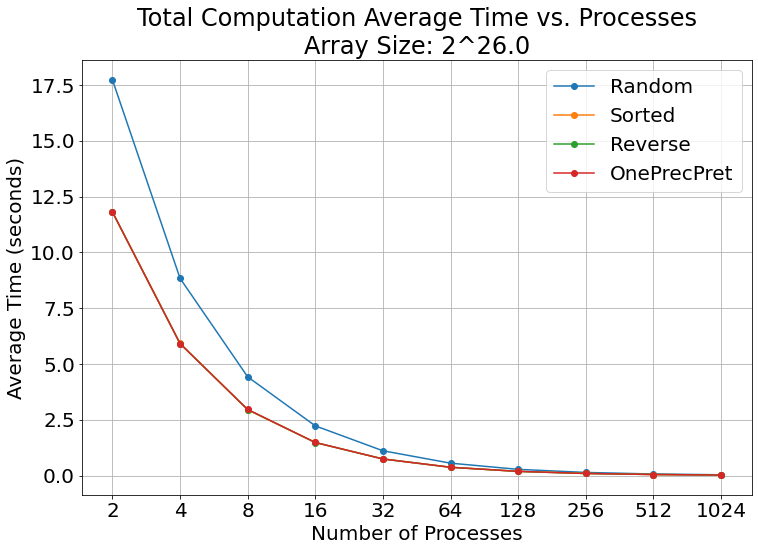

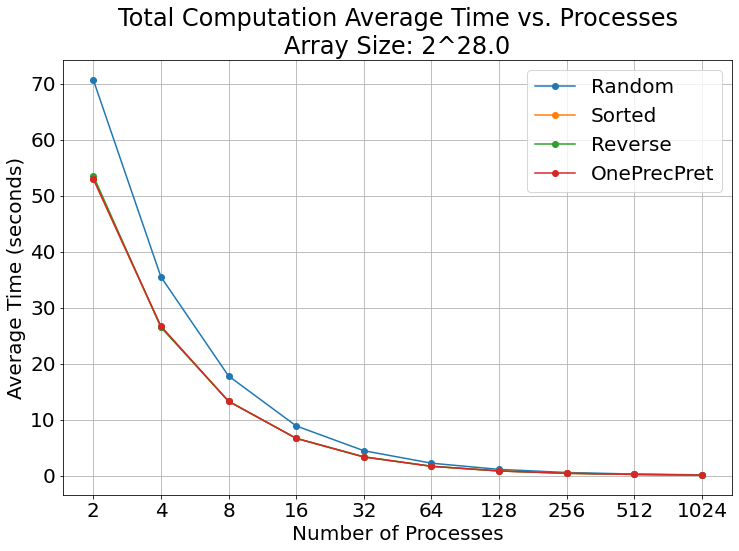

In [195]:
import matplotlib.pyplot as plt

# STRONG SCALING COMPUTATION TOTAL
def extract_and_plot_times(array_siz, tk): # Define the types for which we want to plot (e.g., 1: 'Random', 2: 'Sorted', 3: 'Reverse Sorted')

    # Define sections of timing data to analyze
    timing_sections = {
        'whole_program': 'main',
        'initialization': 'data_init_runtime',
        'communication': 'comm',
        'computation': 'comp'
    }

    def plot_timing_section(array_size, section_name, marker_name, processes):
        plt.figure(figsize=(12, 8))

        # Loop over each array type to get its average times
        for array_type in array_types:
            # Group data and calculate averages for each array type
            avg_times = tk.dataframe.groupby(['num_procs', 'array_size', 'array_type', 'name']).min()['Avg time/rank']
            avg_times_list = []

            for num_proc in processes:
                try:
                    # Append the average times for each process count for the current array type
                    #andrew is really cool :D
                    # thank you
                    avg_times_list.append(avg_times.loc[(num_proc, array_size, array_type, marker_name)])
                except KeyError:
                    print(f"Missing data for process count {num_proc} and array type {array_type}")
                    continue

            indices = list(range(len(avg_times_list)))  # Uniform spacing
            plt.plot(indices, avg_times_list, marker='o', label=f'{array_type}')

        plt.title(f'{section_name} Average Time vs. Processes\nArray Size: 2^{math.log2(array_size)}')
        plt.xlabel('Number of Processes')
        plt.ylabel('Average Time (seconds)')
        plt.xticks(indices, processes)  # Set custom x-axis labels for processes
        plt.legend()
        plt.grid(True)
        plt.show()

    # Define the process counts explicitly
    processes = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
    
    for a_size in array_sizes:
#         plot_timing_section(a_size, 'Whole Program', timing_sections['whole_program'], processes)
#         plot_timing_section(a_size, 'Total Communication', 'comm', processes)
        plot_timing_section(a_size, 'Total Computation', timing_sections['computation'], processes)
    
# updated so that array size doesn't matter
extract_and_plot_times(int(2**22), tk)

In [196]:
import matplotlib.pyplot as plt
import numpy as np

def create_speedup_graph(tk, markerName, array_size=2**26, array_types=["Random", "Sorted", "Reverse", "OnePrecPret"]):
    # Define processor counts
    processors = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
    
    def get_execution_times(array_type, marker_name='comm'):
        # Get average times for a specific array type
        times = {
            'avg': tk.dataframe.groupby(['num_procs', 'array_size', 'array_type', 'name']).min()['Avg time/rank']
        }
        avg_times = []
        for num_proc in processors:
            try:
                avg_times.append(times['avg'].loc[(num_proc, array_size, array_type, marker_name)])
            except KeyError as e:
                print(f"Missing data for {array_type} at process count {num_proc}")
                return None
        return avg_times
    
    plt.figure(figsize=(12, 8))
    
    for array_type in array_types:
        # Get execution times for each array type
        execution_times = get_execution_times(array_type, markerName)
        
        if execution_times is None:
            continue
        
        # Calculate speedup using 2 processors as baseline
        baseline_time = execution_times[0] * 2  # Time for 2 processors * 2
        speedup = [baseline_time / t for t in execution_times]  # Speedup as a ratio
        
        # Plot speedup for the current array type
        plt.plot(processors, speedup, marker='o', linestyle='-', linewidth=2,
                 label=f'Speedup ({array_type})', markersize=8)
    
    # Customize the plot
    plt.xscale('log', base=2)
#     plt.yscale('log', base=2)
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.title(f'Speedup vs. Number of Processors\nArray Size: 2^{math.log2(array_size)} for Different Array Types {markerName}', fontsize=14, pad=20)
    plt.xlabel('Number of Processors', fontsize=12)
    plt.ylabel('Speedup (ratio)', fontsize=12)
    
    plt.legend(fontsize=10, loc='upper left')
    
    # Set axis limits
    plt.xlim(1, 1100)  # Slightly larger than 1024 to show full range
#     plt.ylim(min(speedup) - 0.5, max(speedup) + 0.5)
    
    # Add tick marks for all processor counts
    plt.xticks(processors, [str(p) for p in processors], rotation=45)
#     y_ticks = np.arange(2.0, 3.1, 0.1)
#     plt.yticks(y_ticks)
    
    # Format y-axis ticks as ratios
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.1f}'.format(y)))
    
    plt.tight_layout()
    plt.show()

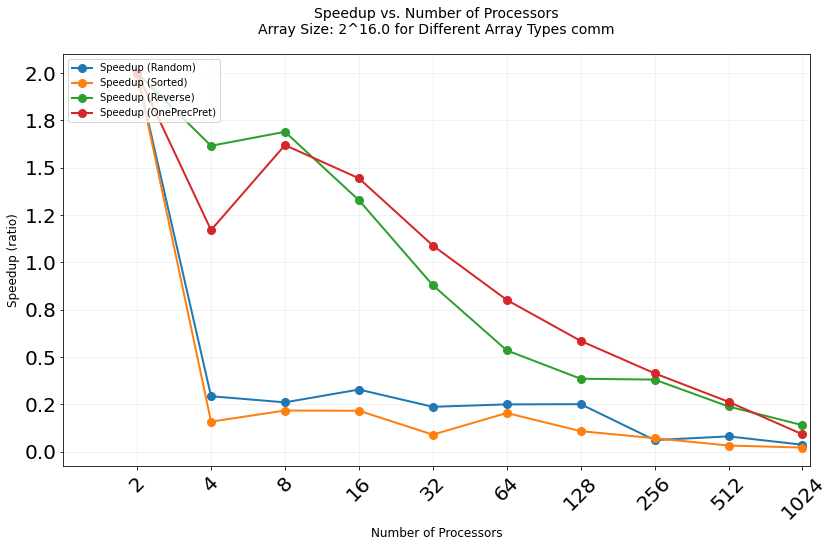

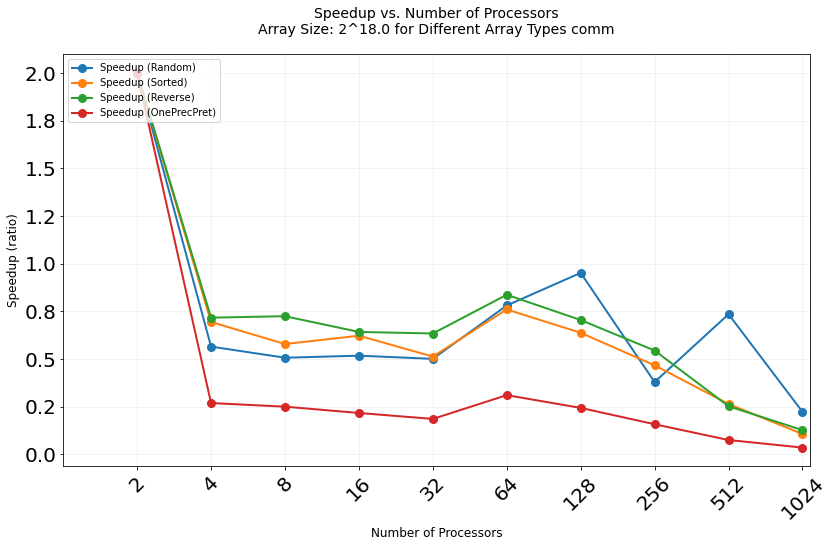

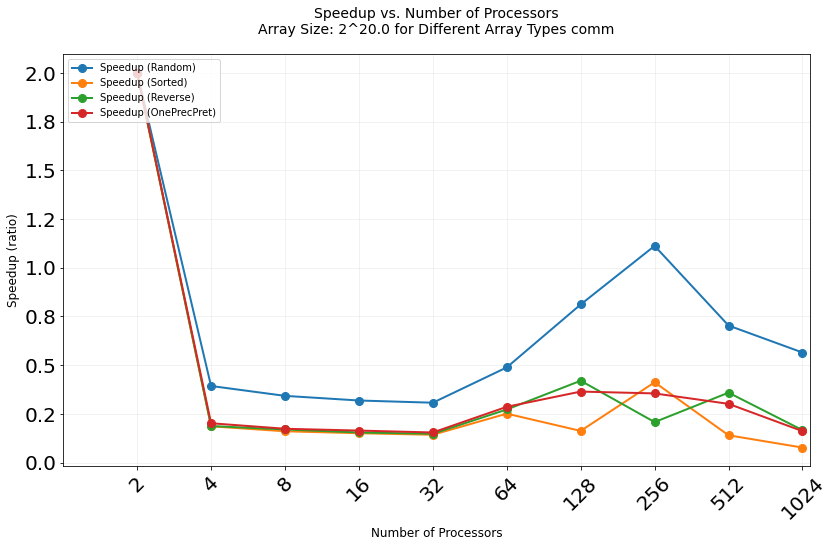

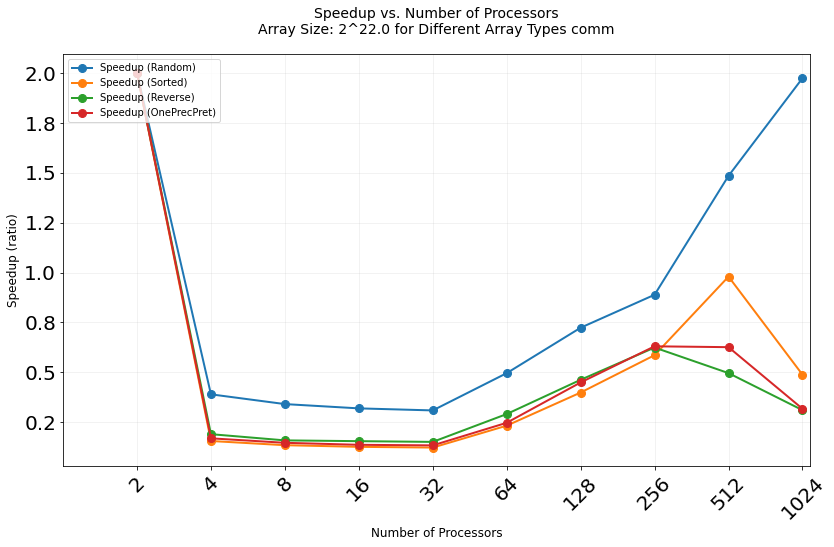

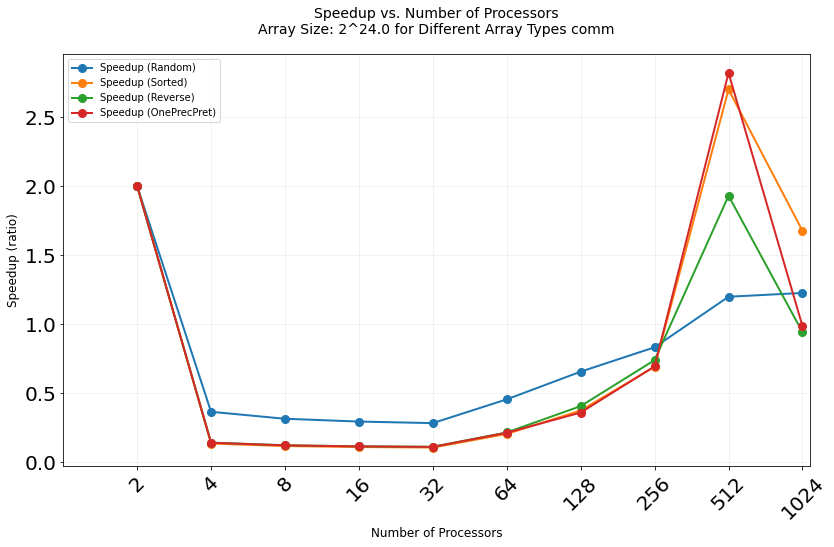

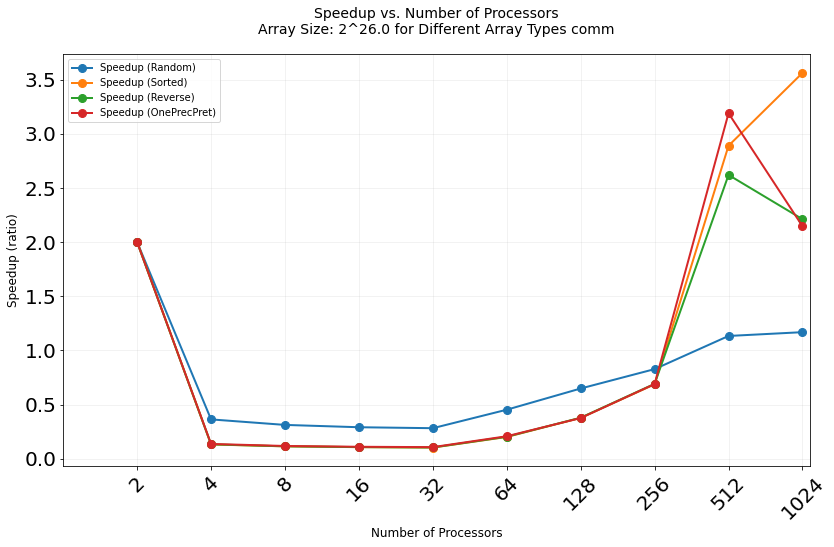

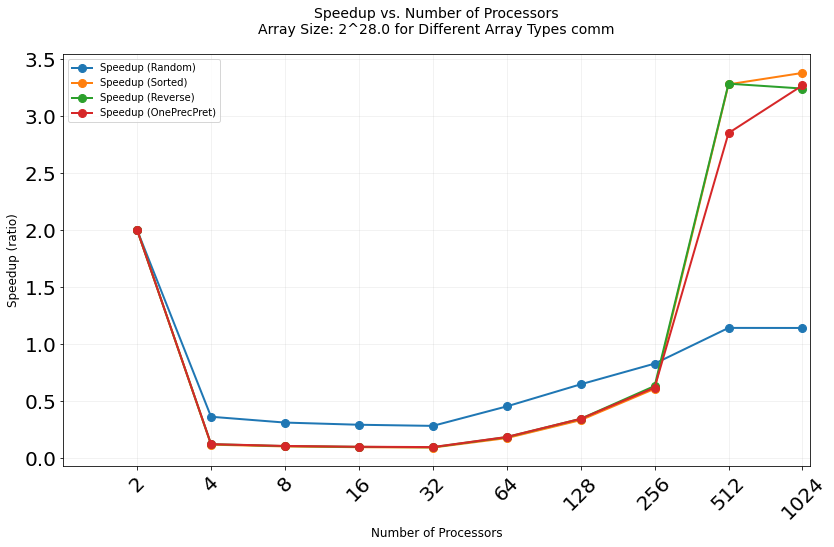

In [197]:
# SPEED UP COMM 
for a_s in array_sizes:
    create_speedup_graph(tk,'comm', a_s)

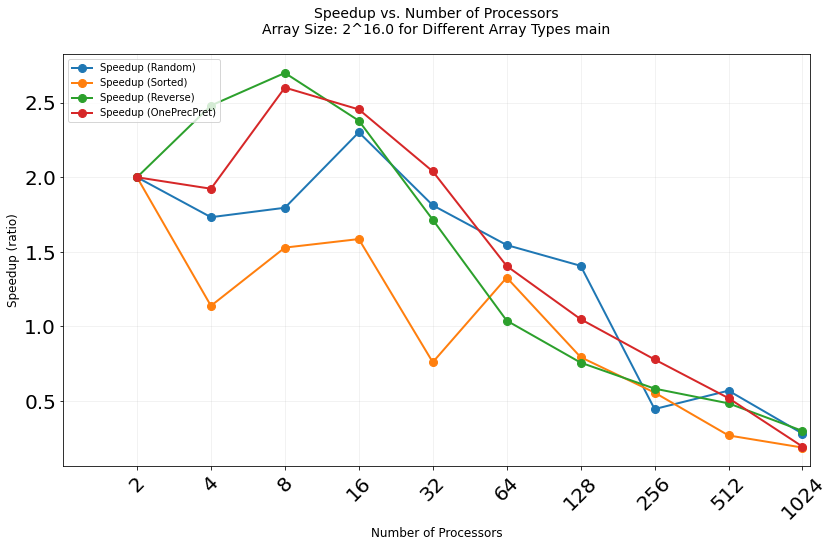

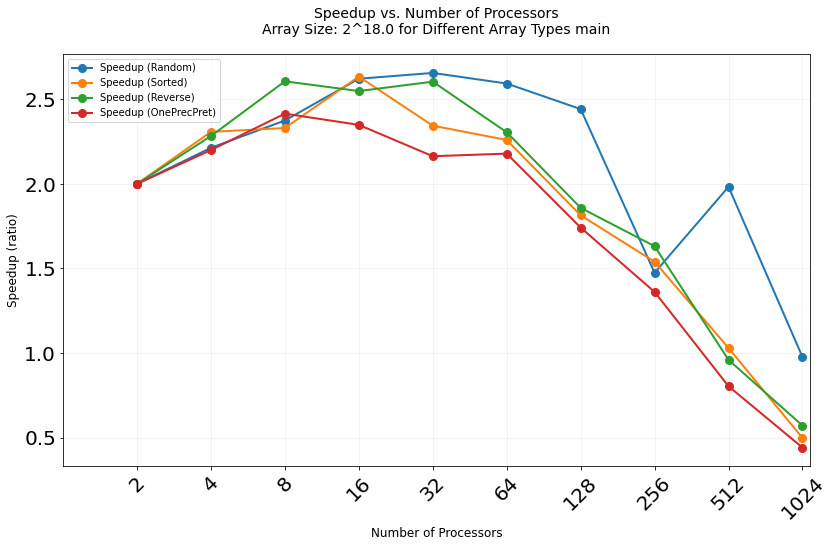

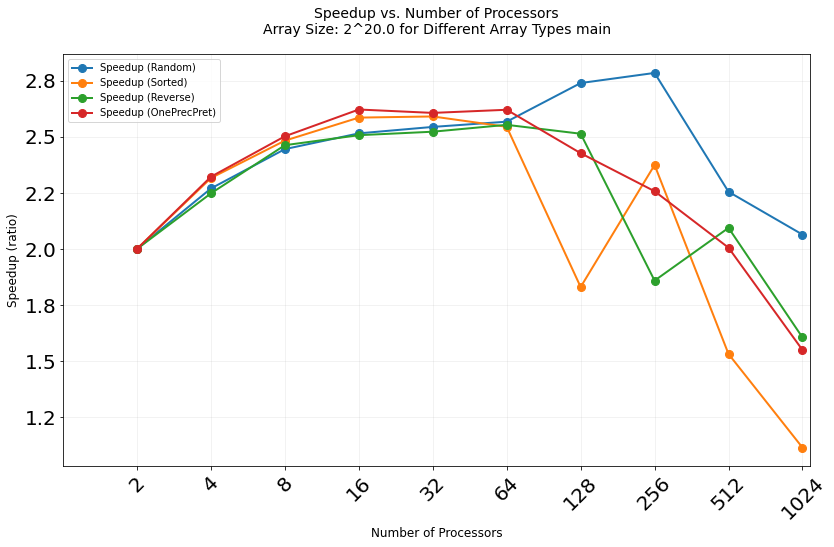

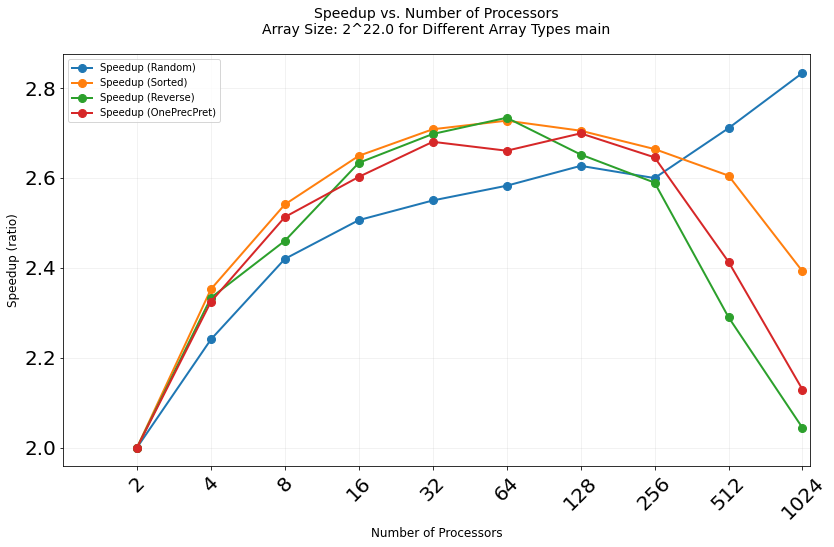

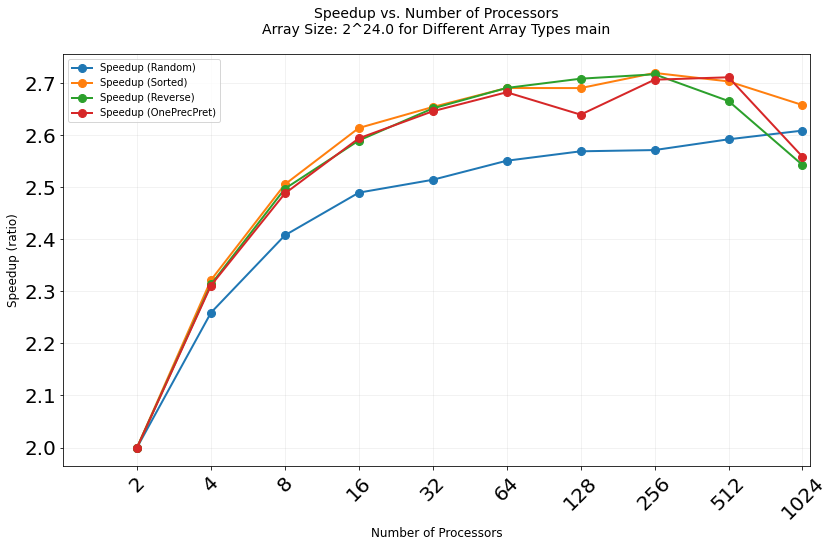

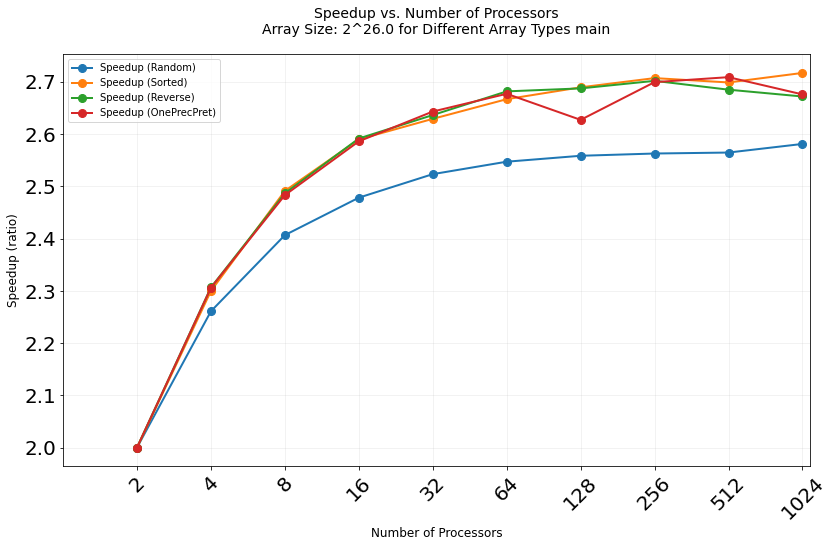

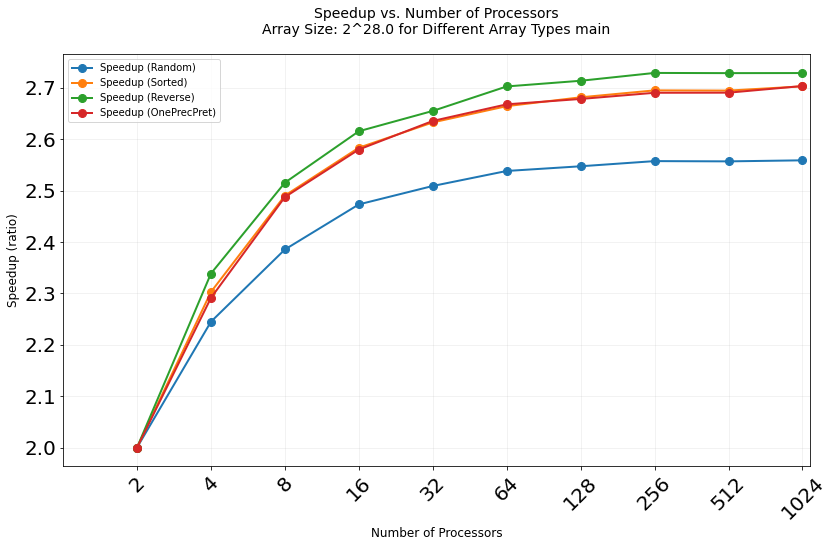

In [198]:
# SPEED UP WHOLE  
for a_s in array_sizes:
    create_speedup_graph(tk,'main', a_s)

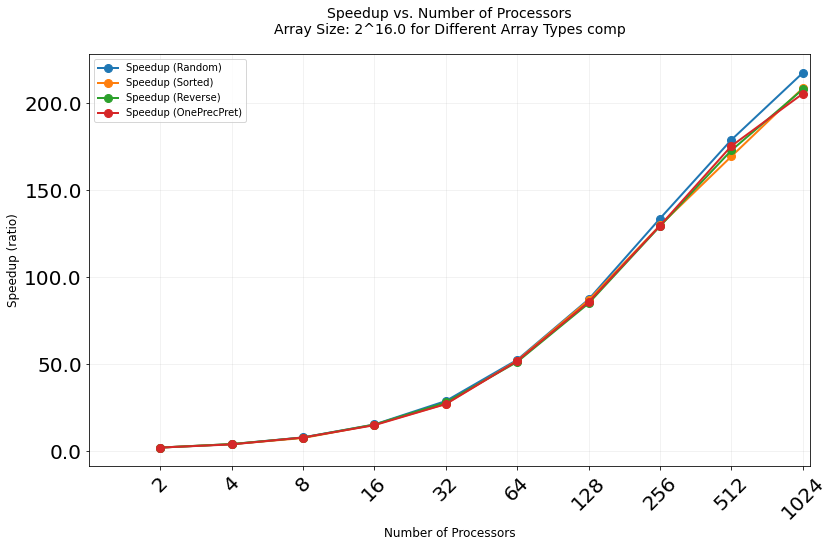

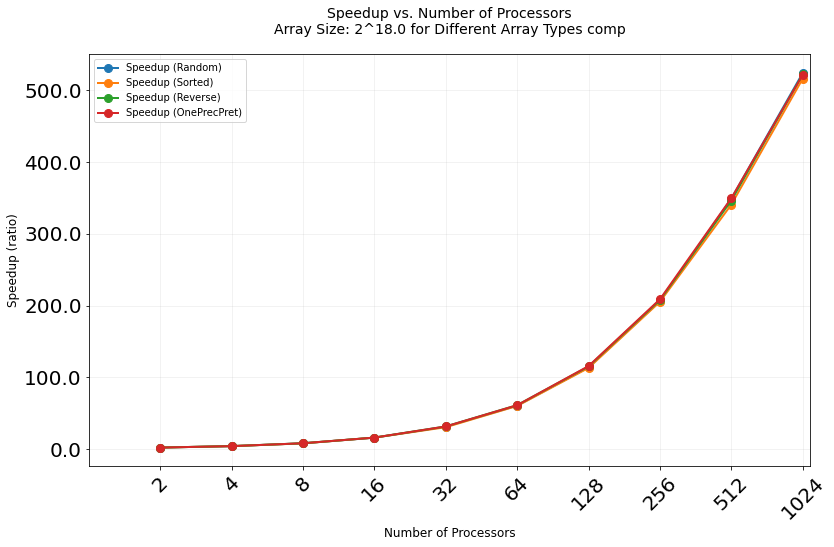

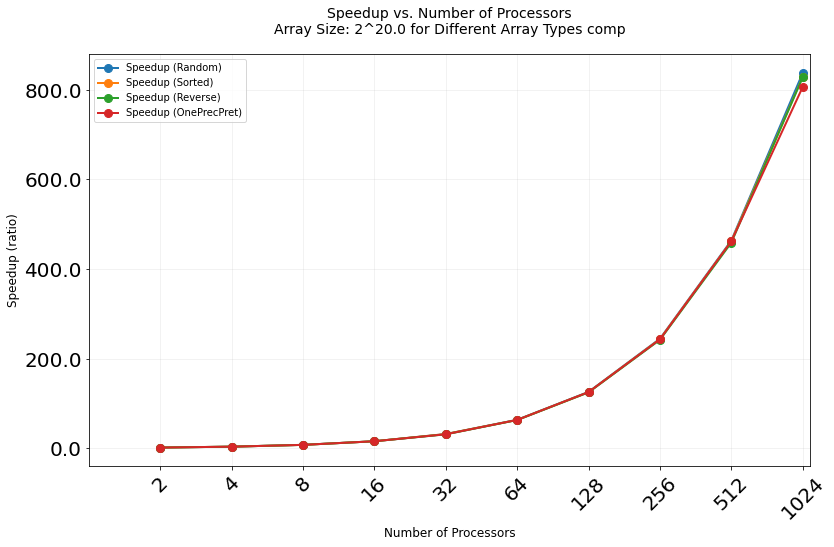

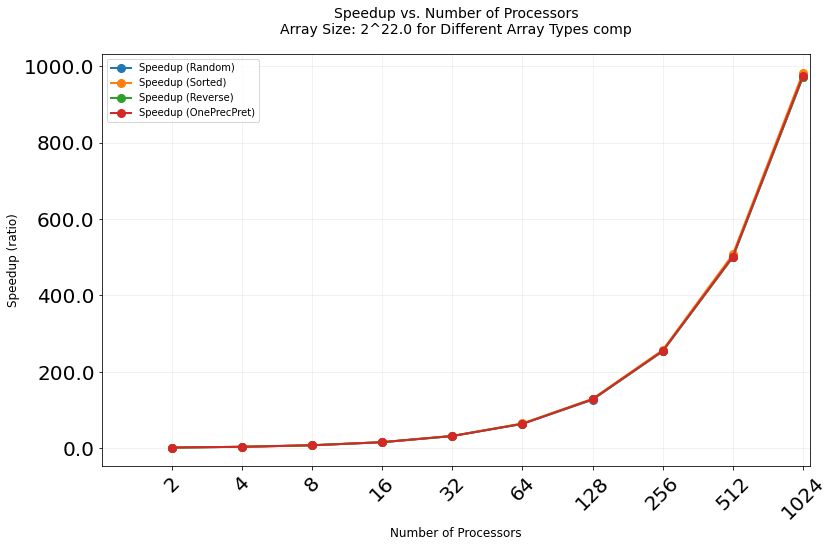

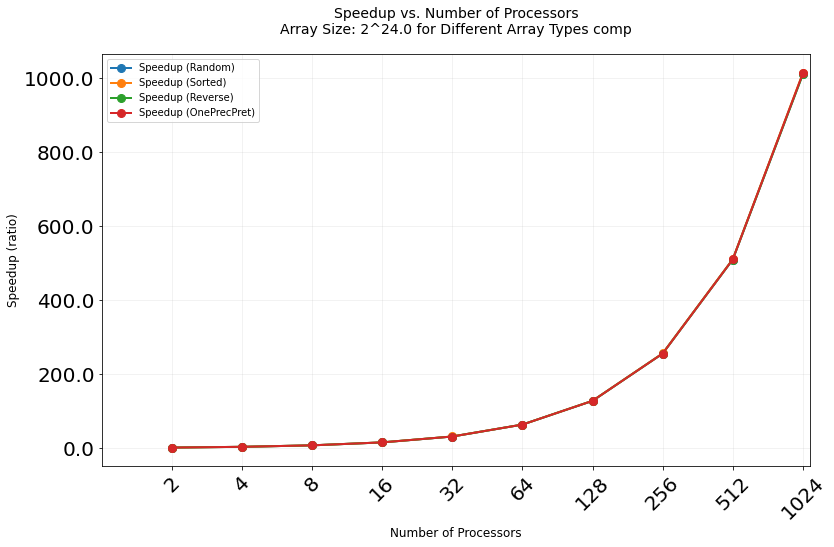

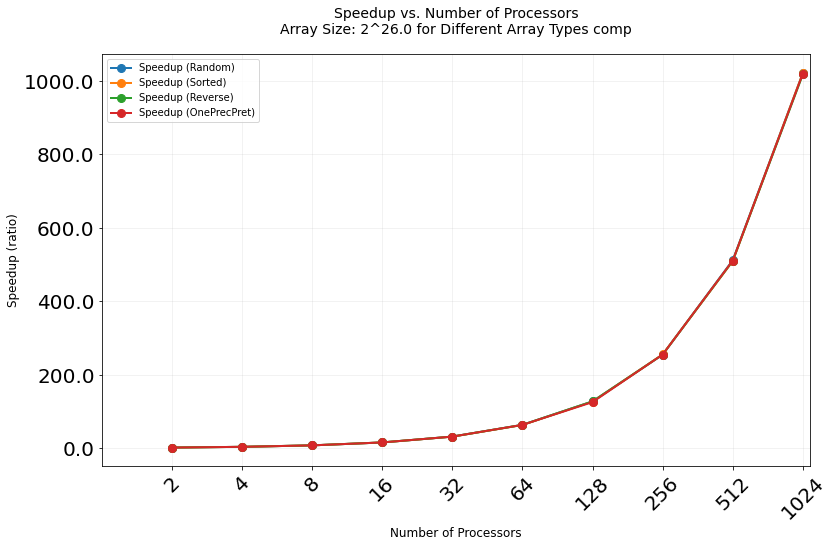

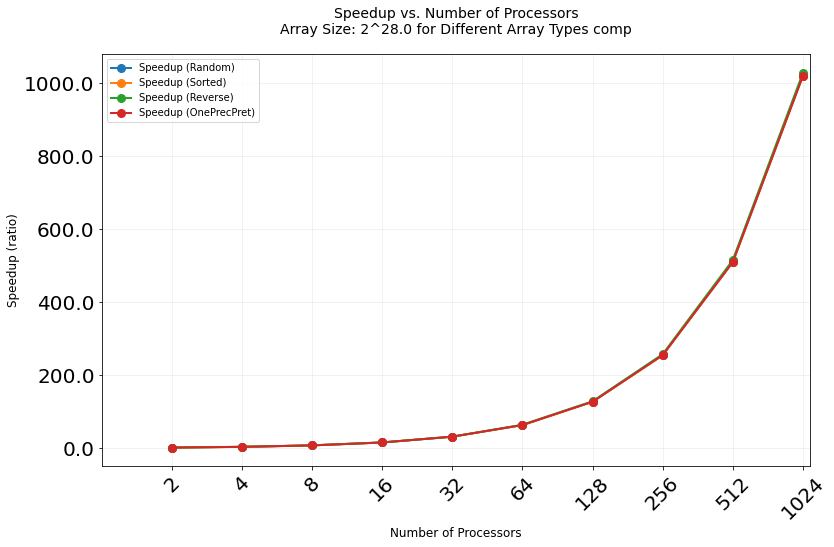

In [199]:
# SPEED UP COMPUTATION
for a_s in array_sizes:
    create_speedup_graph(tk,'comp', a_s)

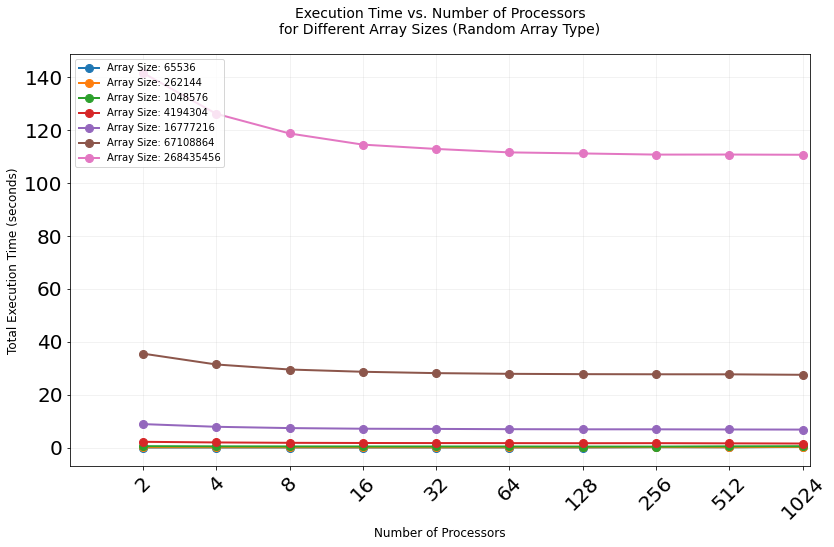

In [200]:
import matplotlib.pyplot as plt
import numpy as np

def create_execution_time_graph(tk, array_sizes=[2**16, 2**18, 2**20, 2**22, 2**24, 2**26, 2**28], array_type="Random"):
    # Define processor counts
    processors = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
    
    def get_execution_times(array_size, array_type, marker_name='main'):
        # Extract average times for a specific array size and array type
        times = {
            'avg': tk.dataframe.groupby(['num_procs', 'array_size', 'array_type', 'name']).min()['Avg time/rank']
        }
        
        avg_times = []
        for num_proc in processors:
            try:
                avg_times.append(times['avg'].loc[(num_proc, array_size, array_type, marker_name)])
            except KeyError as e:
                print(f"Missing data for array size {array_size} at process count {num_proc}")
                return None
        return avg_times

    plt.figure(figsize=(12, 8))
    
    for array_size in array_sizes:
        # Get execution times for each array size
        execution_times = get_execution_times(array_size, array_type)
        
        if execution_times is None:
            continue
        
        # Plot execution time for the current array size
        plt.plot(processors, execution_times, marker='o', linestyle='-', linewidth=2,
                 label=f'Array Size: {array_size}', markersize=8)
    
    
    # Customize the plot
    plt.xscale('log', base=2)
#     plt.yscale('log')
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.title(f'Execution Time vs. Number of Processors\nfor Different Array Sizes ({array_type} Array Type)', fontsize=14, pad=20)
    plt.xlabel('Number of Processors', fontsize=12)
    plt.ylabel('Total Execution Time (seconds)', fontsize=12)
    
    plt.legend(fontsize=10, loc='upper left')
    
    # Set axis limits
    plt.xlim(1, 1100)  # Slightly larger than 1024 to show full range
    
    # Add tick marks for all processor counts
    plt.xticks(processors, [str(p) for p in processors], rotation=45)
    
    plt.tight_layout()
    plt.show()
    
#     # Print detailed execution time for each array size
#     print("\nDetailed Execution Time Analysis for Each Array Size:")
#     print("------------------------------------------------------")
#     for array_size in array_sizes:
#         execution_times = get_execution_times(array_size, array_type)
#         if execution_times is None:
#             continue
#         print(f"\nArray Size: {array_size}")
#         print(f"{'Processors':<12} {'Execution Time (s)':<20}")
#         print("----------------------------------")
#         for p, t in zip(processors, execution_times):
#             print(f"{p:<12} {t:.<20.2f}")

# Call the function with your toolkit object
create_execution_time_graph(tk)


In [201]:
# Define the weak scaling function
def plot_weak_scaling(tk, processes, array_sizes, array_types, mark):
    # Define the section of timing data to analyze
    timing_section_name = mark  # Adjust to use the appropriate timing metric if different
    
    plt.figure(figsize=(12, 8))

    # Loop over each array type to plot its average times
    for array_type in array_types:
        avg_times_list = []

        # Loop over each processor count and array size pair
        for num_proc, array_size in zip(processes, array_sizes):
            try:
                # Group data and calculate the minimum average time for each combination
                avg_times = tk.dataframe.groupby(['num_procs', 'array_size', 'array_type', 'name']).min()['Avg time/rank']
                avg_time = avg_times.loc[(num_proc, array_size, array_type, mark)] 
                avg_times_list.append(avg_time)
            except KeyError:
                print(f"Missing data for process count {num_proc} and array type {array_type}")
                avg_times_list.append(None)

        # Plot the data for this array type
        plt.plot(processes, avg_times_list, marker='o', label=f'{array_type}')

    # Add labels and formatting
    plt.title(f'Weak Scaling: {timing_section_name} vs. Number of Processes')
    plt.xlabel('Number of Processes')
    plt.ylabel('Total Time (seconds)')
    plt.xticks(processes)
    
    plt.xscale('log', base=2)
    

    # Annotate array sizes along the x-axis at each processor count
    for i, (proc, array_size) in enumerate(zip(processes, array_sizes)):
        plt.annotate(f'2^{math.log2(array_size)}', (proc, avg_times_list[i]), textcoords="offset points", xytext=(0,5), ha='center')
    
    plt.legend()
    plt.grid(True)
    plt.show()


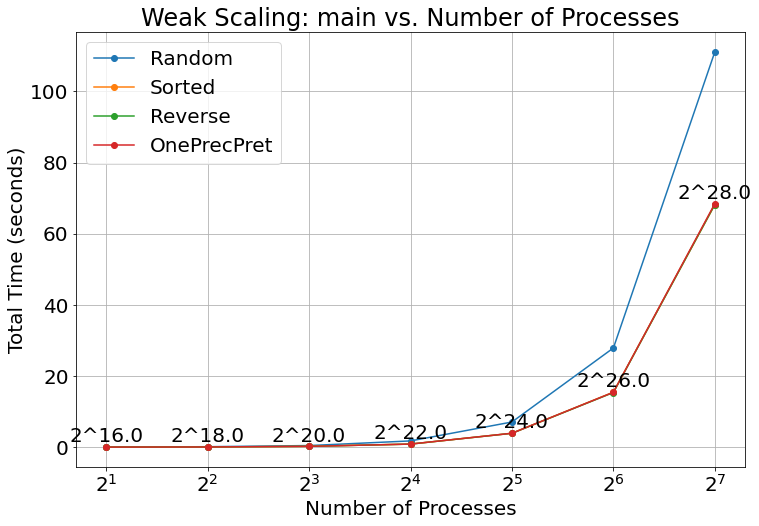

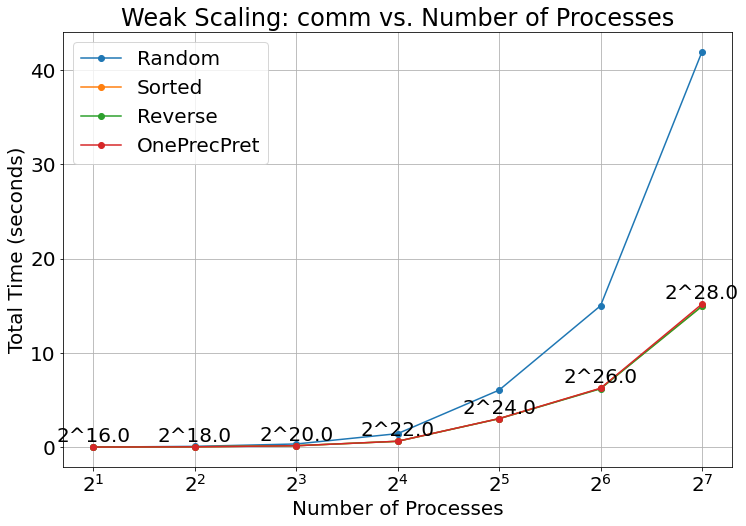

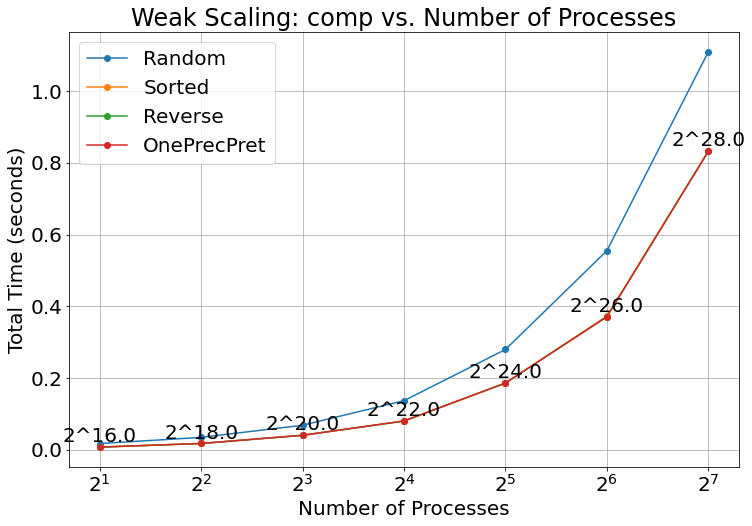

In [202]:

# WEAK SCALING FOR ALL ARRAY SIZES
plot_weak_scaling(tk, processes[:7], array_sizes, array_types, "main")
plot_weak_scaling(tk, processes[:7], array_sizes, array_types, "comm")
plot_weak_scaling(tk, processes[:7], array_sizes, array_types, "comp")